A quick notebook for comparing the zigzag and hilbert embeddings on CIFAR-10

In [1]:
# Imports
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit

from fastai.basics import *
from timm.loss import SoftTargetCrossEntropy


import sys
sys.path.append('..')

from src.tokenizers.hilbert_embedding import HilbertEmbedding
from src.tokenizers.random_embedding import RandomEmbedding
from src.tokenizers.zigzag_embedding import ZigzagEmbedding
from src.models.vit import VisionTransformer
from src.models.altvit import SimpleViT, HilbertViT
from src.training.scheduler import WarmupCosineScheduler
from src.training.train import train, evaluate

# Set global variables
torch.backends.cudnn.benchmark = True

/home/remco/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Initialize the enviroment. Everything here is as closely implemented as the experimental setup in the GFPE-ViT paper

In [ ]:
def init_hilbert_model():
    """
    Initialize the Vision Transformer model with Hilbert embedding.

    Returns:
        model (VisionTransformer): The initialized Vision Transformer model with Hilbert embedding.
        optimizer (torch.optim.Optimizer): AdamW optimizer for training the model.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Cosine Annealing LR scheduler for learning rate adjustment.
    """
    patch_embed = HilbertEmbedding(
        img_size=32,
        patch_size=4,
        in_channels=3,
        embed_dim=256
    )

    model = VisionTransformer(
        patch_embed=patch_embed,
        depth=6,
        n_heads=4,
        mlp_dim=256,
        num_classes=10
    ).to(device)

    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.00005,
        betas=(0.9, 0.999)
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=10,
        eta_min=0.0001
    )

    return model, optimizer, scheduler


def init_zigzag_model():
    """
    Initialize the Vision Transformer model with Zigzag embedding.

    Returns:
        model (VisionTransformer): The initialized Vision Transformer model with Zigzag embedding.
        optimizer (torch.optim.Optimizer): AdamW optimizer for training the model.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Cosine Annealing LR scheduler for learning rate adjustment.
    """
    patch_embed = ZigzagEmbedding(
        img_size=32,
        patch_size=4,
        in_channels=3,
        embed_dim=256
    )

    model = VisionTransformer(
        patch_embed=patch_embed,
        depth=6,
        n_heads=4,
        mlp_dim=256,
        num_classes=10
    ).to(device)

    optimizer = optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=0.00005,
        betas=(0.9, 0.999)
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=10,
        eta_min=0.0001
    )

    return model, optimizer, scheduler


# Define the device to be used for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std deviation
])

# Define the training loss criterion (Soft Target Cross Entropy for mixup)
# train_criterion = SoftTargetCrossEntropy()
train_criterion = nn.CrossEntropyLoss()

# Define the testing loss criterion (Standard Cross Entropy Loss)
test_criterion = nn.CrossEntropyLoss()


Now we're going to load in the dataset and model. For now we've implemented CIFAR-10

In [3]:
def load_data(dataset_name):
    """Load and return PyTorch-ready datasets."""
    if dataset_name == 'cifar10':
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomCrop(32, padding=4),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
        ])
        train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        return train_set, test_set

    elif dataset_name == 'caltech256':
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )

        transform_train = transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.RandomResizedCrop(128, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
        ])

        transform_val = transforms.Compose([
            transforms.Lambda(lambda img: img.convert("RGB")),
            transforms.Resize(256),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            normalize
        ])

        # 2) Download once (no transform) to extract labels
        raw_dataset = datasets.Caltech256(
            root="./data/caltech256",
            download=True,
            transform=None
        )
        # Caltech256 stores its integer labels in .y
        labels = np.array(raw_dataset.y)

        # 3) Stratified split
        sss = StratifiedShuffleSplit(
            n_splits=1, test_size=0.2, random_state=42
        )
        train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))

        # 4) Now create two dataset objects with the proper transforms
        dataset_train = datasets.Caltech256(
            root="./data/caltech256",
            download=False,
            transform=transform_train
        )
        dataset_val = datasets.Caltech256(
            root="./data/caltech256",
            download=False,
            transform=transform_val
        )

        # 5) Wrap in Subset and DataLoader
        train_set = Subset(dataset_train, train_idx)
        val_set   = Subset(dataset_val,   val_idx)

        return train_set, val_set

    elif dataset_name == 'imagenette':
        path = untar_data(URLs.IMAGENETTE_320)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        transform_train = transforms.Compose([
            transforms.RandomResizedCrop(128, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
            transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')
        ])

        transform_val = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            normalize
        ])

        train_dataset = datasets.ImageFolder(os.path.join(path, 'train'), transform=transform_train)
        val_dataset = datasets.ImageFolder(os.path.join(path, 'val'), transform=transform_val)

        return train_dataset, val_dataset

    else:
        raise ValueError(f"Dataset '{dataset_name}' not supported.")

train_set, test_set = load_data('cifar10')
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Visualize the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.3489903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0219827..1.8757682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2158318..2.04885].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.2928383].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..1.8562579].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2739866.

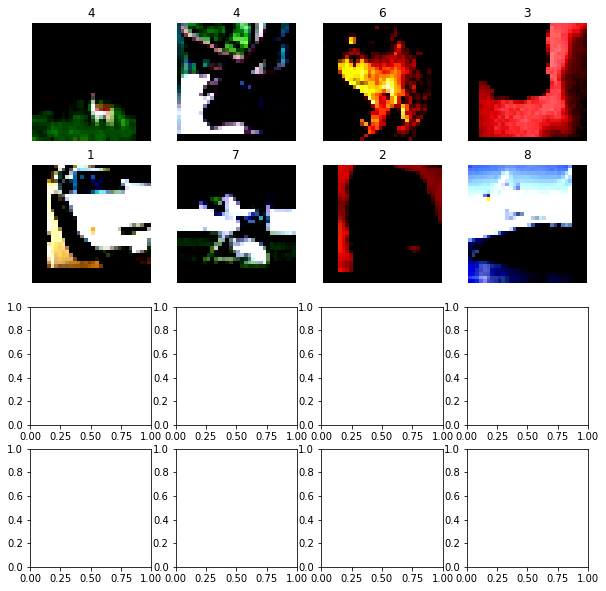

In [4]:
# Show 16 random images from the training set
def show_images(images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(8):
        ax = axes[i // 4, i % 4]
        ax.imshow(images[i].permute(1, 2, 0).numpy())
        ax.set_title(labels[i].item())
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
images, labels = next(iter(train_loader))
# Show the images
show_images(images, labels)

Now we're going to train the hilbert model and the zigzag model each for 10 epochs five times on the CIFAR-10 dataset.
We will save the model weights and the training history for each run.

In [5]:
iterations = 1
epochs = 10

def train_and_evaluate_model(iterations, epochs, init_function=None):
    train_accuracies = []
    test_accuracies = []
    for iter in range(iterations):
        model, optimizer, _ = init_function()
        model.to(device)
        iter_train_acc = []
        iter_test_acc = []
        for epoch in range(epochs):
            train_loss, train_acc = train(
                model, train_loader, train_criterion, optimizer, device
            )
            test_loss, test_acc = evaluate(model, test_loader, test_criterion, device)

            iter_train_acc.append(train_acc)
            iter_test_acc.append(test_acc)

            print(
                f"Iteration {iter+1}, Epoch {epoch+1}: "
                f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
                f"Test Loss={test_loss:.4f}, Acc={test_acc:.4f}"
            )
        train_accuracies.append(iter_train_acc)
        test_accuracies.append(iter_test_acc)
    return train_accuracies, test_accuracies

train_accuracies_zigzag, test_accuracies_zigzag = train_and_evaluate_model(
    iterations, epochs, init_zigzag_model)
train_accuracies_hilbert, test_accuracies_hilbert = train_and_evaluate_model(
    iterations, epochs, init_hilbert_model)

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.00 GiB. GPU 0 has a total capacity of 7.67 GiB of which 7.48 GiB is free. Including non-PyTorch memory, this process has 146.00 MiB memory in use. Of the allocated memory 9.57 MiB is allocated by PyTorch, and 439.00 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Now we're going to visualize the training history of the hilbert and zigzag models.

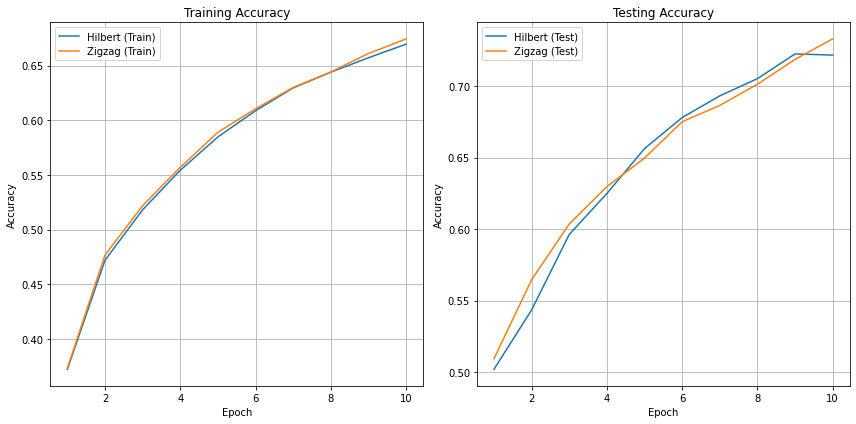

In [ ]:
# Convert to numpy arrays
train_hilbert = np.array(train_accuracies_hilbert)
test_hilbert = np.array(test_accuracies_hilbert)
train_zigzag = np.array(train_accuracies_zigzag)
test_zigzag = np.array(test_accuracies_zigzag)

# Compute mean and std deviation
def compute_stats(data):
    return data.mean(axis=0), data.std(axis=0)

train_h_mean, train_h_std = compute_stats(train_hilbert)
test_h_mean, test_h_std = compute_stats(test_hilbert)
train_z_mean, train_z_std = compute_stats(train_zigzag)
test_z_mean, test_z_std = compute_stats(test_zigzag)

# Plotting
epochs_range = np.arange(1, epochs + 1)

plt.figure(figsize=(12, 6))

# Training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_h_mean, label="Hilbert (Train)")
plt.fill_between(epochs_range, train_h_mean - train_h_std, train_h_mean + train_h_std, alpha=0.2)
plt.plot(epochs_range, train_z_mean, label="Zigzag (Train)")
plt.fill_between(epochs_range, train_z_mean - train_z_std, train_z_mean + train_z_std, alpha=0.2)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_h_mean, label="Hilbert (Test)")
plt.fill_between(epochs_range, test_h_mean - test_h_std, test_h_mean + test_h_std, alpha=0.2)
plt.plot(epochs_range, test_z_mean, label="Zigzag (Test)")
plt.fill_between(epochs_range, test_z_mean - test_z_std, test_z_mean + test_z_std, alpha=0.2)
plt.title("Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()